In [1]:
from datetime import datetime, timedelta, date
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from constants import *
from pandas_tools import multi_index_add as add
from animated_vaccinations import *
from vaccination import *

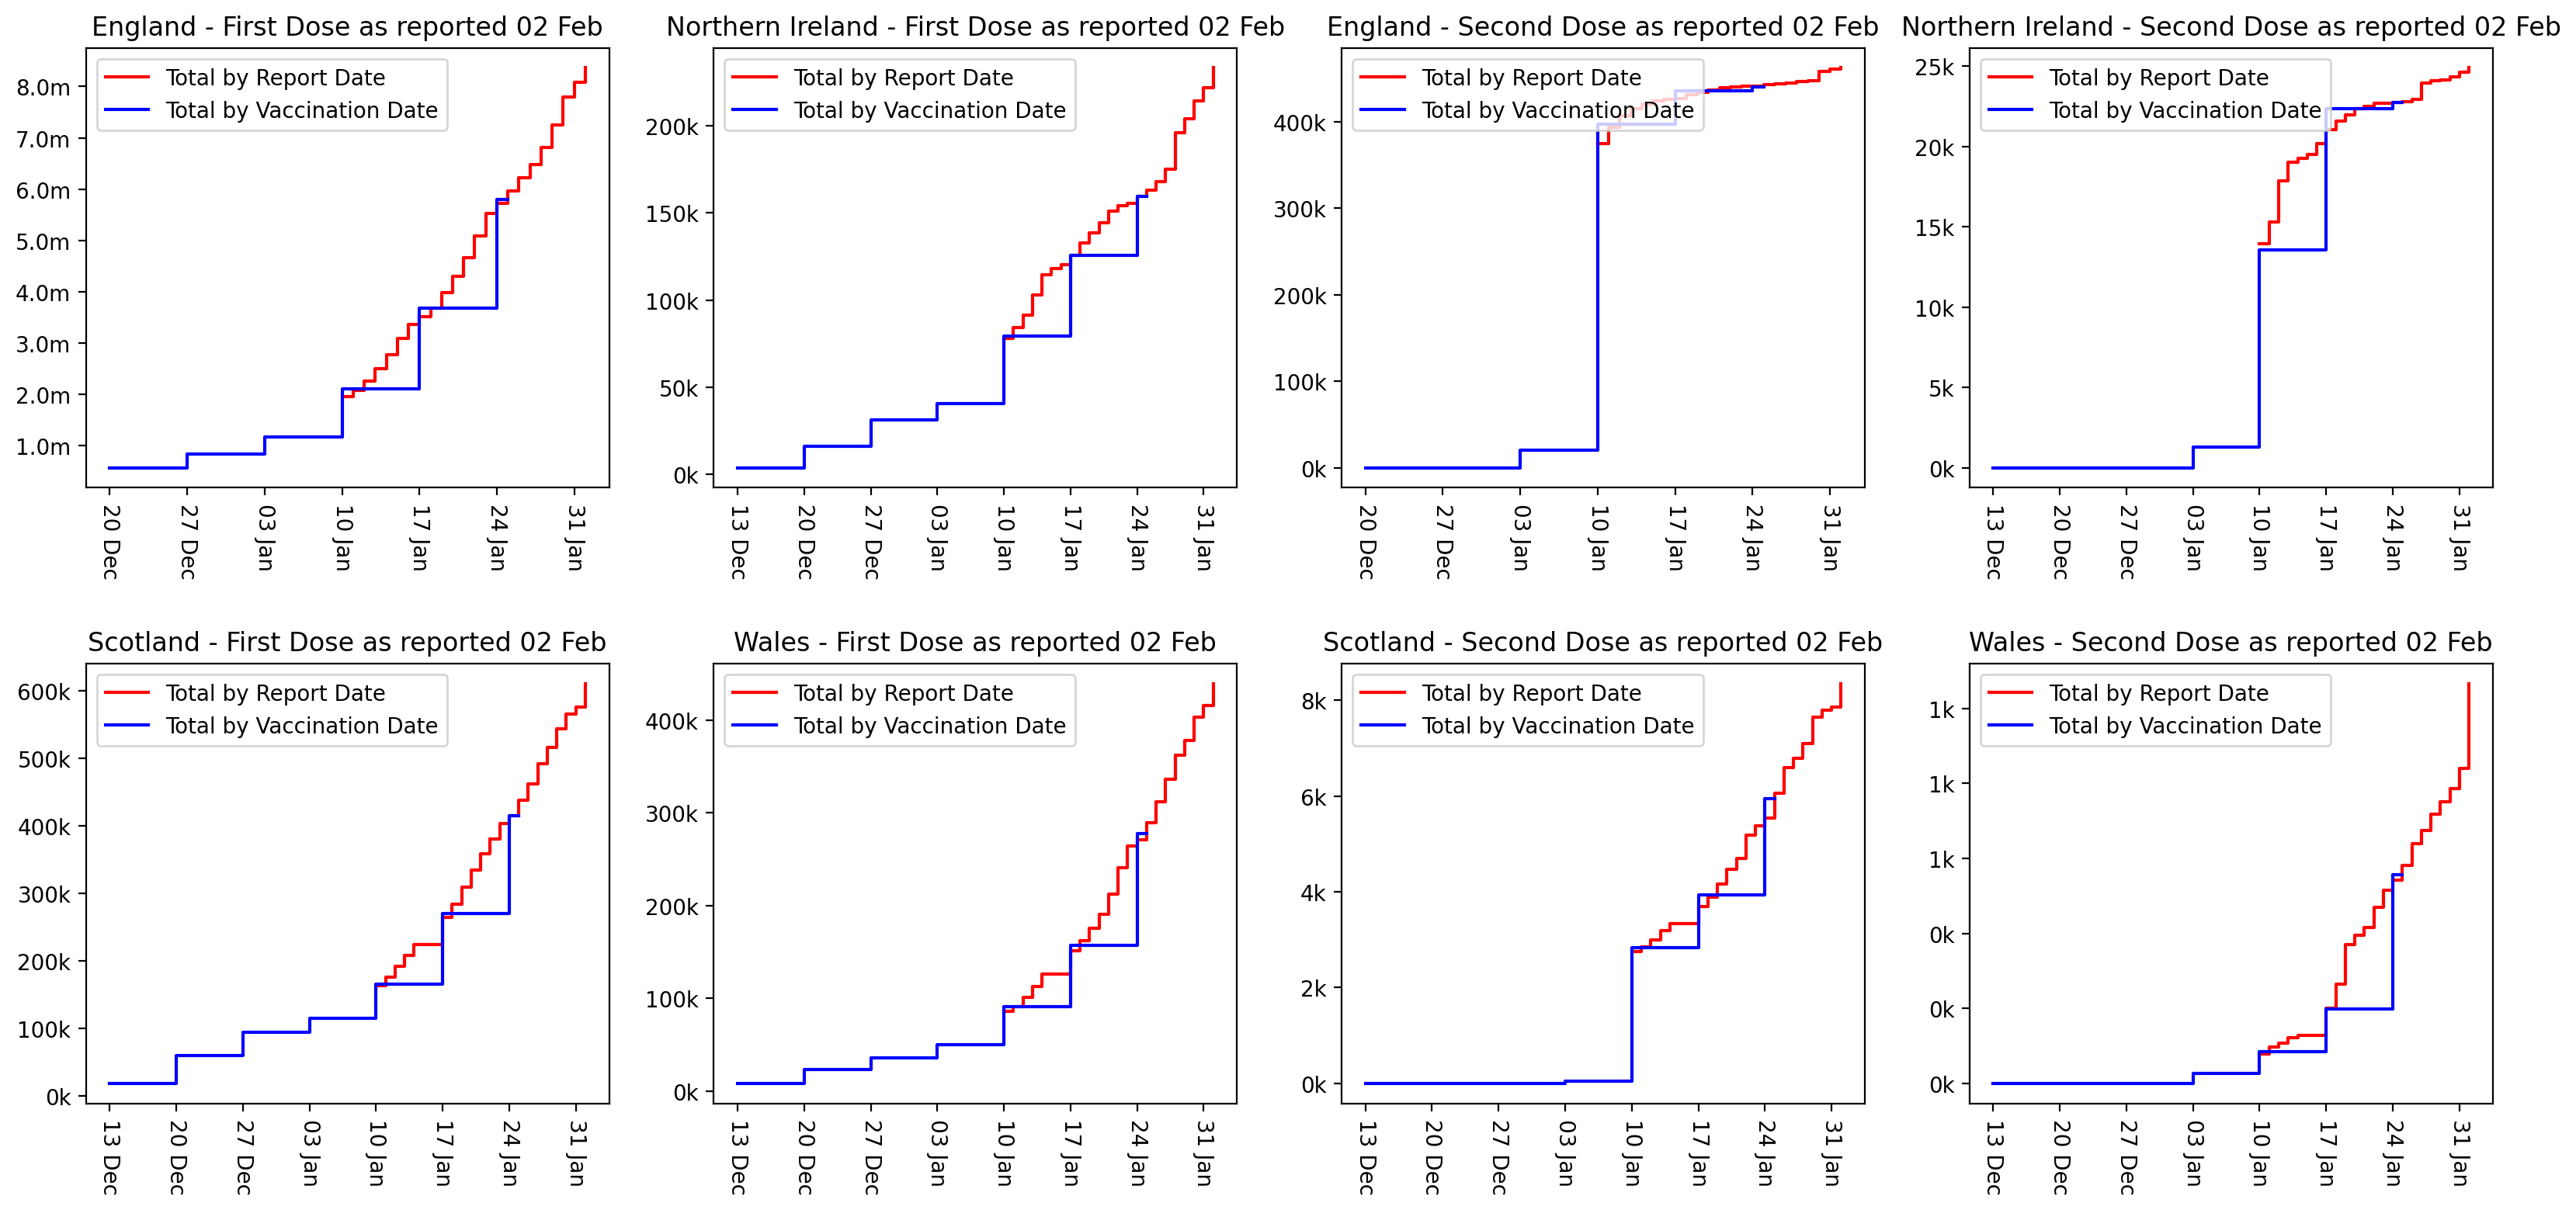

In [2]:
render_plots(selection_mapping()['everything'])

In [3]:
raw, data_date = raw_vaccination_data()
not_complete = ~raw.columns.str.contains('Complete')
by_publish_metrics = raw.columns[raw.columns.str.contains('ByPublishDate') & not_complete]
by_vaccination_metrics = raw.columns[
    raw.columns.str.contains('ByVaccinationDate') & raw.columns.str.startswith('cum') & not_complete
]
metrics = by_publish_metrics | by_vaccination_metrics

In [4]:
pivoted = raw.pivot(index=date_col, columns=area_name, values=metrics)
by_vaccination_index = pivoted[by_vaccination_metrics].dropna(axis='rows', how='all').index
interesting_index = by_vaccination_index.union(by_vaccination_index+timedelta(days=1))
filled = pivoted.fillna(method='ffill')
interesting = filled.loc[filled.index.intersection(interesting_index)].dropna(
    axis='rows', how='all', subset=product(by_publish_metrics, filled.columns.levels[1])
)
add(interesting, 'calc_first', interesting[first_dose_daily_cum] - interesting[first_dose_weekly_cum])
add(interesting, 'calc_second', interesting[second_dose_daily_cum] - interesting[second_dose_weekly_cum])
interesting.columns = interesting.columns.swaplevel()
for area in interesting.columns.levels[0]:
    ordered = interesting[area][[
        first_dose_daily_cum, first_dose_weekly_cum, 'calc_first', first_dose_daily_new,
        second_dose_daily_cum, second_dose_weekly_cum, 'calc_second', second_dose_daily_new,
    ]]
    ordered.index.name=''
    ordered.rename(inplace=True, columns={
        first_dose_daily_cum: '1st Dose (Daily)',
        first_dose_weekly_cum: '1st Dose (Weekly)',
        'calc_first': '+/-',
        first_dose_daily_new: '1st Dose (New)',
        second_dose_daily_cum: '2nd Dose (Daily)',
        second_dose_weekly_cum: '2nd Dose (Weekly)',
        'calc_second': '+/-',
        second_dose_daily_new: '2nd Dose (New)',
    })
    display(f'For {area}:', ordered)

'For England:'

,1st Dose (Daily),1st Dose (Weekly),+/-,1st Dose (New),2nd Dose (Daily),2nd Dose (Weekly),+/-,2nd Dose (New)
,,,,,,,,
2021-01-10,1959151.0,2102669.0,-143518.0,NaN,374613.0,397274.0,-22661.0,NaN
2021-01-11,2080280.0,2102669.0,-22389.0,121129.0,393925.0,397274.0,-3349.0,19312.0
2021-01-17,3520056.0,3676257.0,-156201.0,154564.0,427386.0,435650.0,-8264.0,1284.0
2021-01-18,3687206.0,3676257.0,10949.0,167150.0,431136.0,435650.0,-4514.0,3750.0
2021-01-24,5727693.0,5792159.0,-64466.0,198592.0,441684.0,440425.0,1259.0,610.0
2021-01-25,5962544.0,5792159.0,170385.0,234851.0,443010.0,440425.0,2585.0,1326.0


'For Northern Ireland:'

,1st Dose (Daily),1st Dose (Weekly),+/-,1st Dose (New),2nd Dose (Daily),2nd Dose (Weekly),+/-,2nd Dose (New)
,,,,,,,,
2021-01-10,78005.0,79080.0,-1075.0,NaN,13949.0,13558.0,391.0,NaN
2021-01-11,84187.0,79080.0,5107.0,6182.0,15288.0,13558.0,1730.0,1339.0
2021-01-17,125717.0,125717.0,0.0,5330.0,21016.0,22326.0,-1310.0,842.0
2021-01-18,132857.0,125717.0,7140.0,7140.0,21579.0,22326.0,-747.0,563.0
2021-01-24,159642.0,159642.0,0.0,3998.0,22713.0,22713.0,0.0,26.0
2021-01-25,163317.0,159642.0,3675.0,3675.0,22795.0,22713.0,82.0,82.0


'For Scotland:'

,1st Dose (Daily),1st Dose (Weekly),+/-,1st Dose (New),2nd Dose (Daily),2nd Dose (Weekly),+/-,2nd Dose (New)
,,,,,,,,
2021-01-10,163377.0,166409.0,-3032.0,NaN,2758.0,2833.0,-75.0,NaN
2021-01-11,175942.0,166409.0,9533.0,12565.0,2857.0,2833.0,24.0,99.0
2021-01-17,264991.0,270162.0,-5171.0,40151.0,3698.0,3940.0,-242.0,367.0
2021-01-18,284582.0,270162.0,14420.0,19591.0,3886.0,3940.0,-54.0,188.0
2021-01-24,415402.0,415269.0,133.0,11364.0,5538.0,5940.0,-402.0,155.0
2021-01-25,437900.0,415269.0,22631.0,22498.0,6060.0,5940.0,120.0,522.0


'For Wales:'

,1st Dose (Daily),1st Dose (Weekly),+/-,1st Dose (New),2nd Dose (Daily),2nd Dose (Weekly),+/-,2nd Dose (New)
,,,,,,,,
2021-01-10,86039.0,90698.0,-4659.0,NaN,79.0,85.0,-6.0,NaN
2021-01-11,91239.0,90698.0,541.0,5200.0,97.0,85.0,12.0,18.0
2021-01-17,151737.0,157387.0,-5650.0,25362.0,201.0,198.0,3.0,72.0
2021-01-18,161932.0,157387.0,4545.0,10195.0,265.0,198.0,67.0,64.0
2021-01-24,270833.0,277690.0,-6857.0,6295.0,543.0,556.0,-13.0,27.0
2021-01-25,289566.0,277690.0,11876.0,18733.0,581.0,556.0,25.0,38.0


In [2]:
for dt in pd.date_range(earliest_vaccination, date.today()-timedelta(days=1)):
    changes = vaccination_changes(dt, exclude_okay=True)
    if changes:
        display(changes)

,,First Dose (New),Second Dose (New),First Dose (Total),Second Dose (Total)
,,,,,
England,10 Jan 21,+0,+0,"+1,959,151","+374,613"
Northern Ireland,10 Jan 21,+0,+0,"+78,005","+13,949"
Scotland,10 Jan 21,+0,+0,"+163,377","+2,758"
Wales,10 Jan 21,+0,+0,"+86,039",+79


,,First Dose (New),Second Dose (New),First Dose (Total),Second Dose (Total)
,,,,,
Northern Ireland,16 Jan 21,"-20,172",+0,"-20,172",+0
